# Import packages


In [71]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings

# Load data


In [72]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


In [73]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [74]:
train_data, test_data, all_data, test_data_start_list = load_data(stock_name, date_predict_start, data_range, slide_range, n_slide)

In [75]:
all_data.iloc[23449]

Open            4.228290e+03
High            4.236390e+03
Low             4.188130e+03
Close           4.188430e+03
Volume          4.560700e+09
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Name: 2021-05-10, dtype: float64

In [76]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0
...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0


# Data preprocessing


In [77]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [78]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [79]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [80]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [81]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [82]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [83]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [84]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [85]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [86]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [87]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [88]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [89]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [90]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [91]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [92]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [93]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [94]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [95]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [96]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [97]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [98]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

In [99]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)


In [100]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,2953.909912,NaN,peak
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [101]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.random import shuffle

In [102]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [103]:
base_day = 30
prediction_day = base_day
slide = base_day

In [104]:
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)

In [105]:
x_train['data_0'].shape

(190, 30, 1)

In [106]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units=prediction_day))
    return model

In [107]:
input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)

In [108]:
def build_Lstm_model(prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [39]:
model = build_Lstm_model(prediction_day, input_shape)

In [40]:
from tqdm import tqdm

In [41]:
def train_Lstm_model():
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [42]:
history = train_Lstm_model()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
5/5 [==============================] - 19s 968ms/step - loss: 0.0389 - val_loss: 0.1952
Epoch 2/25
5/5 [==============================] - 1s 209ms/step - loss: 0.0328 - val_loss: 0.1957
Epoch 3/25
5/5 [==============================] - 1s 213ms/step - loss: 0.0314 - val_loss: 0.1760
Epoch 4/25
5/5 [==============================] - 1s 206ms/step - loss: 0.0297 - val_loss: 0.2050
Epoch 5/25
5/5 [==============================] - 1s 206ms/step - loss: 0.0284 - val_loss: 0.1882
Epoch 6/25
5/5 [==============================] - 1s 214ms/step - loss: 0.0274 - val_loss: 0.2031
Epoch 7/25
5/5 [==============================] - 1s 261ms/step - loss: 0.0261 - val_loss: 0.2209
Epoch 8/25
5/5 [==============================] - 1s 223ms/step - loss: 0.0258 - val_loss: 0.2421
Epoch 8: early stopping


 10%|█         | 1/10 [00:26<03:57, 26.37s/it]

Epoch 1/25
5/5 [==============================] - 16s 715ms/step - loss: 0.0492 - val_loss: 0.2614
Epoch 2/25
5/5 [==============================] - 1s 201ms/step - loss: 0.0435 - val_loss: 0.2583
Epoch 3/25
5/5 [==============================] - 1s 190ms/step - loss: 0.0403 - val_loss: 0.2560
Epoch 4/25
5/5 [==============================] - 1s 188ms/step - loss: 0.0391 - val_loss: 0.2603
Epoch 5/25
5/5 [==============================] - 1s 197ms/step - loss: 0.0383 - val_loss: 0.2541
Epoch 6/25
5/5 [==============================] - 1s 189ms/step - loss: 0.0368 - val_loss: 0.2446
Epoch 7/25
5/5 [==============================] - 1s 190ms/step - loss: 0.0362 - val_loss: 0.2707
Epoch 8/25
5/5 [==============================] - 1s 185ms/step - loss: 0.0378 - val_loss: 0.2481
Epoch 9/25
5/5 [==============================] - 1s 202ms/step - loss: 0.0356 - val_loss: 0.2641
Epoch 10/25
5/5 [==============================] - 1s 209ms/step - loss: 0.0361 - val_loss: 0.2563
Epoch 11/25
5/5 [=

 20%|██        | 2/10 [00:52<03:28, 26.00s/it]

Epoch 1/25
5/5 [==============================] - 32s 2s/step - loss: 0.1015 - val_loss: 0.2997
Epoch 2/25
5/5 [==============================] - 1s 233ms/step - loss: 0.0671 - val_loss: 0.2905
Epoch 3/25
5/5 [==============================] - 1s 246ms/step - loss: 0.0633 - val_loss: 0.2801
Epoch 4/25
5/5 [==============================] - 1s 247ms/step - loss: 0.0602 - val_loss: 0.2883
Epoch 5/25
5/5 [==============================] - 1s 253ms/step - loss: 0.0571 - val_loss: 0.2835
Epoch 6/25
5/5 [==============================] - 1s 244ms/step - loss: 0.0540 - val_loss: 0.2782
Epoch 7/25
5/5 [==============================] - 1s 261ms/step - loss: 0.0533 - val_loss: 0.2774
Epoch 8/25
5/5 [==============================] - 1s 312ms/step - loss: 0.0514 - val_loss: 0.2367
Epoch 9/25
5/5 [==============================] - 1s 248ms/step - loss: 0.0496 - val_loss: 0.2253
Epoch 10/25
5/5 [==============================] - 1s 239ms/step - loss: 0.0490 - val_loss: 0.2268
Epoch 11/25
5/5 [====

 30%|███       | 3/10 [01:39<04:11, 35.96s/it]

Epoch 1/25
5/5 [==============================] - 21s 2s/step - loss: 0.1449 - val_loss: 0.2899
Epoch 2/25
5/5 [==============================] - 1s 311ms/step - loss: 0.0854 - val_loss: 0.2753
Epoch 3/25
5/5 [==============================] - 1s 302ms/step - loss: 0.0744 - val_loss: 0.2651
Epoch 4/25
5/5 [==============================] - 1s 260ms/step - loss: 0.0718 - val_loss: 0.2615
Epoch 5/25
5/5 [==============================] - 1s 281ms/step - loss: 0.0695 - val_loss: 0.2532
Epoch 6/25
5/5 [==============================] - 1s 266ms/step - loss: 0.0653 - val_loss: 0.2402
Epoch 7/25
5/5 [==============================] - 1s 257ms/step - loss: 0.0635 - val_loss: 0.2212
Epoch 8/25
5/5 [==============================] - 1s 226ms/step - loss: 0.0608 - val_loss: 0.2042
Epoch 9/25
5/5 [==============================] - 1s 194ms/step - loss: 0.0614 - val_loss: 0.1807
Epoch 10/25
5/5 [==============================] - 1s 240ms/step - loss: 0.0586 - val_loss: 0.1433
Epoch 11/25
5/5 [====

 40%|████      | 4/10 [02:23<03:53, 38.91s/it]

Epoch 1/25
5/5 [==============================] - 31s 1s/step - loss: 0.1509 - val_loss: 0.3508
Epoch 2/25
5/5 [==============================] - 1s 208ms/step - loss: 0.0887 - val_loss: 0.3160
Epoch 3/25
5/5 [==============================] - 1s 184ms/step - loss: 0.0836 - val_loss: 0.2838
Epoch 4/25
5/5 [==============================] - 1s 190ms/step - loss: 0.0820 - val_loss: 0.2814
Epoch 5/25
5/5 [==============================] - 1s 185ms/step - loss: 0.0736 - val_loss: 0.2420
Epoch 6/25
5/5 [==============================] - 1s 191ms/step - loss: 0.0734 - val_loss: 0.2245
Epoch 7/25
5/5 [==============================] - 1s 198ms/step - loss: 0.0698 - val_loss: 0.1902
Epoch 8/25
5/5 [==============================] - 1s 191ms/step - loss: 0.0678 - val_loss: 0.1491
Epoch 9/25
5/5 [==============================] - 1s 185ms/step - loss: 0.0636 - val_loss: 0.1114
Epoch 10/25
5/5 [==============================] - 1s 190ms/step - loss: 0.0634 - val_loss: 0.0782
Epoch 11/25
5/5 [====

 50%|█████     | 5/10 [03:18<03:43, 44.66s/it]

Epoch 1/25
5/5 [==============================] - 38s 696ms/step - loss: 0.0601 - val_loss: 0.2410
Epoch 2/25
5/5 [==============================] - 1s 183ms/step - loss: 0.0439 - val_loss: 0.2019
Epoch 3/25
5/5 [==============================] - 1s 200ms/step - loss: 0.0367 - val_loss: 0.0977
Epoch 4/25
5/5 [==============================] - 1s 199ms/step - loss: 0.0347 - val_loss: 0.1013
Epoch 5/25
5/5 [==============================] - 1s 195ms/step - loss: 0.0309 - val_loss: 0.0987
Epoch 6/25
5/5 [==============================] - 1s 231ms/step - loss: 0.0297 - val_loss: 0.1882
Epoch 7/25
5/5 [==============================] - 1s 223ms/step - loss: 0.0296 - val_loss: 0.0870
Epoch 8/25
5/5 [==============================] - 1s 205ms/step - loss: 0.0294 - val_loss: 0.1035
Epoch 9/25
5/5 [==============================] - 1s 218ms/step - loss: 0.0294 - val_loss: 0.0799
Epoch 10/25
5/5 [==============================] - 1s 200ms/step - loss: 0.0297 - val_loss: 0.0829
Epoch 11/25
5/5 [=

 60%|██████    | 6/10 [04:19<03:21, 50.34s/it]

Epoch 1/25
5/5 [==============================] - 37s 1s/step - loss: 0.1340 - val_loss: 0.3250
Epoch 2/25
5/5 [==============================] - 1s 206ms/step - loss: 0.0601 - val_loss: 0.2455
Epoch 3/25
5/5 [==============================] - 1s 272ms/step - loss: 0.0483 - val_loss: 0.2442
Epoch 4/25
5/5 [==============================] - 1s 198ms/step - loss: 0.0403 - val_loss: 0.2087
Epoch 5/25
5/5 [==============================] - 1s 238ms/step - loss: 0.0336 - val_loss: 0.2044
Epoch 6/25
5/5 [==============================] - 1s 196ms/step - loss: 0.0323 - val_loss: 0.2111
Epoch 7/25
5/5 [==============================] - 1s 187ms/step - loss: 0.0290 - val_loss: 0.2302
Epoch 8/25
5/5 [==============================] - 1s 190ms/step - loss: 0.0277 - val_loss: 0.2296
Epoch 9/25
5/5 [==============================] - 1s 206ms/step - loss: 0.0281 - val_loss: 0.2778
Epoch 10/25
5/5 [==============================] - 1s 283ms/step - loss: 0.0257 - val_loss: 0.2633
Epoch 10: early stopp

 70%|███████   | 7/10 [05:06<02:27, 49.12s/it]

Epoch 1/25
5/5 [==============================] - 37s 2s/step - loss: 0.1633 - val_loss: 0.4832
Epoch 2/25
5/5 [==============================] - 1s 286ms/step - loss: 0.0825 - val_loss: 0.3792
Epoch 3/25
5/5 [==============================] - 1s 304ms/step - loss: 0.0574 - val_loss: 0.3919
Epoch 4/25
5/5 [==============================] - 1s 269ms/step - loss: 0.0474 - val_loss: 0.4759
Epoch 5/25
5/5 [==============================] - 1s 204ms/step - loss: 0.0385 - val_loss: 0.5216
Epoch 6/25
5/5 [==============================] - 1s 225ms/step - loss: 0.0326 - val_loss: 0.6336
Epoch 7/25
5/5 [==============================] - 1s 189ms/step - loss: 0.0310 - val_loss: 0.6167
Epoch 7: early stopping


 80%|████████  | 8/10 [05:50<01:35, 47.65s/it]

Epoch 1/25
5/5 [==============================] - 21s 837ms/step - loss: 0.2099 - val_loss: 0.6538
Epoch 2/25
5/5 [==============================] - 1s 193ms/step - loss: 0.0873 - val_loss: 0.5539
Epoch 3/25
5/5 [==============================] - 1s 198ms/step - loss: 0.0586 - val_loss: 0.7692
Epoch 4/25
5/5 [==============================] - 1s 197ms/step - loss: 0.0465 - val_loss: 0.9348
Epoch 5/25
5/5 [==============================] - 1s 194ms/step - loss: 0.0385 - val_loss: 1.0476
Epoch 6/25
5/5 [==============================] - 1s 203ms/step - loss: 0.0350 - val_loss: 1.0940
Epoch 7/25
5/5 [==============================] - 1s 200ms/step - loss: 0.0304 - val_loss: 1.0540
Epoch 7: early stopping


 90%|█████████ | 9/10 [06:17<00:41, 41.13s/it]

Epoch 1/25
5/5 [==============================] - 30s 886ms/step - loss: 0.2181 - val_loss: 0.9613
Epoch 2/25
5/5 [==============================] - 1s 184ms/step - loss: 0.1061 - val_loss: 0.6272
Epoch 3/25
5/5 [==============================] - 1s 181ms/step - loss: 0.0682 - val_loss: 0.8693
Epoch 4/25
5/5 [==============================] - 1s 192ms/step - loss: 0.0524 - val_loss: 0.8818
Epoch 5/25
5/5 [==============================] - 1s 240ms/step - loss: 0.0451 - val_loss: 0.9461
Epoch 6/25
5/5 [==============================] - 1s 229ms/step - loss: 0.0423 - val_loss: 1.0284
Epoch 7/25
5/5 [==============================] - 1s 197ms/step - loss: 0.0418 - val_loss: 1.0025
Epoch 7: early stopping


100%|██████████| 10/10 [06:53<00:00, 41.33s/it]


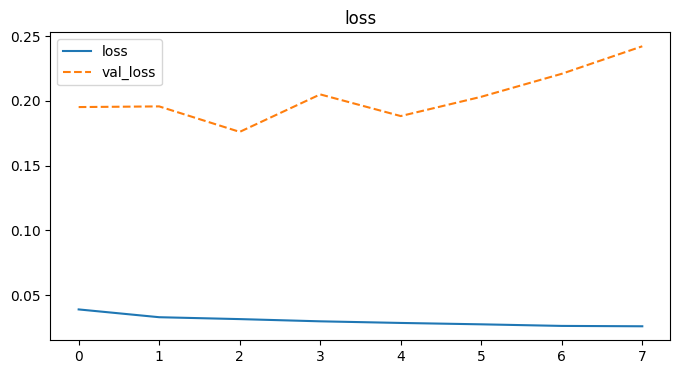

In [43]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()


In [44]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [45]:
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

In [46]:
test_data['data_2']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-01-31,3282.330078,3282.330078,3214.679932,3225.520020,4529700000,0.0,0.0,NaN,3225.520020,valley
1,2020-02-03,3235.659912,3268.439941,3235.659912,3248.919922,3760460000,0.0,0.0,NaN,NaN,NaN
2,2020-02-04,3280.610107,3306.919922,3280.610107,3297.590088,3996900000,0.0,0.0,NaN,NaN,NaN
3,2020-02-05,3324.909912,3337.580078,3313.750000,3334.689941,4121480000,0.0,0.0,NaN,NaN,NaN
4,2020-02-06,3344.919922,3347.959961,3334.389893,3345.780029,3887250000,0.0,0.0,3345.780029,NaN,peak
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-01-21,3857.459961,3861.449951,3845.050049,3853.070068,4501760000,0.0,0.0,3853.070068,NaN,peak
246,2021-01-22,3844.239990,3852.310059,3830.409912,3841.469971,5110890000,0.0,0.0,NaN,3841.469971,valley
247,2021-01-25,3851.679932,3859.229980,3797.159912,3855.360107,7000840000,0.0,0.0,3855.360107,NaN,peak
248,2021-01-26,3862.959961,3870.899902,3847.780029,3849.620117,6137500000,0.0,0.0,NaN,NaN,NaN


In [47]:
def predicting_creat_processed_signal_Lstm(x_test, test_data):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [48]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data)

1/1 [==============================] - 7s 7s/step


In [49]:
processed_signal['data_0'][0]

,Close
0,0.263056
1,0.281695
2,0.237002
3,0.236612
4,0.208123
...,...
235,0.078516
236,0.119399
237,0.220183
238,0.119732


In [50]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)


In [51]:
# processed_signal = processed_signal_FFT

In [52]:
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

In [53]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [54]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,2953.909912,NaN,peak
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [55]:
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)

In [56]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,2953.909912,NaN,peak
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [57]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [58]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date t_date lead ans_date      pv error best_fit
data_0  2020-01-02    NaN -1.0      NaN    peak  2.11        0
data_1  2020-01-16    NaN  3.0      NaN  valley  2.29        0
data_2  2020-01-31    NaN -1.0      NaN  valley  2.41        0
data_3  2020-02-14    NaN  7.0      NaN  valley  2.69        0
data_4  2020-03-02    NaN  1.0      NaN    peak  2.45        0
data_5  2020-03-16    NaN  4.0      NaN  valley  2.68        0
data_6  2020-03-30    NaN -1.0      NaN    peak  2.72        0
data_7  2020-04-14    NaN -1.0      NaN  valley  2.74        0
data_8  2020-04-28    NaN -1.0      NaN    peak   2.6        0
data_9  2020-05-12    NaN  1.0      NaN    peak  2.91        0


In [59]:
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date      t_date lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-03 -1.0  2020-01-02    peak  2.11        0
data_1  2020-01-16  2020-01-22  3.0  2020-01-27  valley  2.29        0
data_2  2020-01-31  2020-02-03 -1.0  2020-01-31  valley  2.41        0
data_3  2020-02-14  2020-02-19  7.0  2020-02-28  valley  2.69        0
data_4  2020-03-02  2020-03-03  1.0  2020-03-04    peak  2.45        0
data_5  2020-03-16  2020-03-17  4.0  2020-03-23  valley  2.68        0
data_6  2020-03-30  2020-03-31 -1.0  2020-03-30    peak  2.72        0
data_7  2020-04-14  2020-04-16 -1.0  2020-04-15  valley  2.74        0
data_8  2020-04-28  2020-04-30 -1.0  2020-04-29    peak   2.6        0
data_9  2020-05-12  2020-05-15  1.0  2020-05-18    peak  2.91        0


In [60]:
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  2.1
            s_date      t_date lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-03 -1.0  2020-01-02    peak  2.11        0
data_1  2020-01-16  2020-01-22  3.0  2020-01-27  valley  2.29        0
data_2  2020-01-31  2020-02-03 -1.0  2020-01-31  valley  2.41        0
data_3  2020-02-14  2020-02-19  7.0  2020-02-28  valley  2.69        0
data_4  2020-03-02  2020-03-03  1.0  2020-03-04    peak  2.45        0
data_5  2020-03-16  2020-03-17  4.0  2020-03-23  valley  2.68        0
data_6  2020-03-30  2020-03-31 -1.0  2020-03-30    peak  2.72        0
data_7  2020-04-14  2020-04-16 -1.0  2020-04-15  valley  2.74        0
data_8  2020-04-28  2020-04-30 -1.0  2020-04-29    peak   2.6        0
data_9  2020-05-12  2020-05-15  1.0  2020-05-18    peak  2.91        0


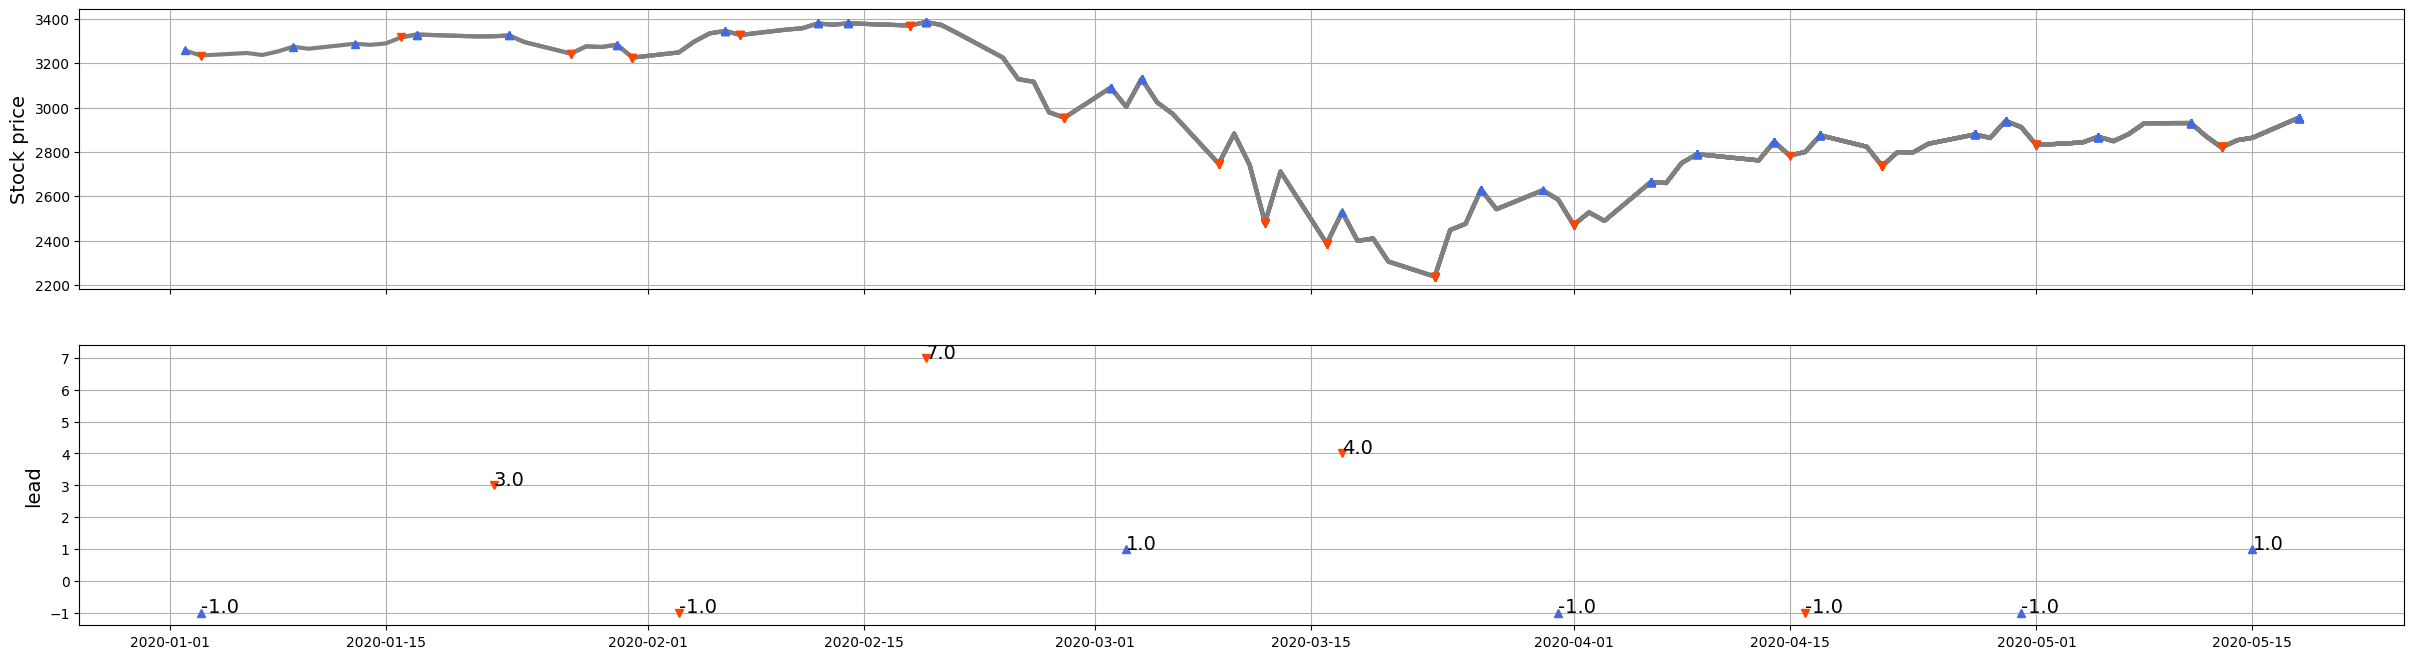

In [61]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

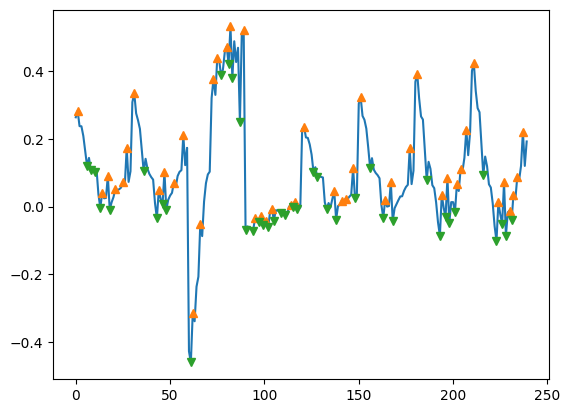

In [62]:
plt.plot(processed_signal['data_0'][0]['Close'])
plt.plot(processed_signal['data_0'][0]['peaks'], '^')
plt.plot(processed_signal['data_0'][0]['valleys'], 'v')

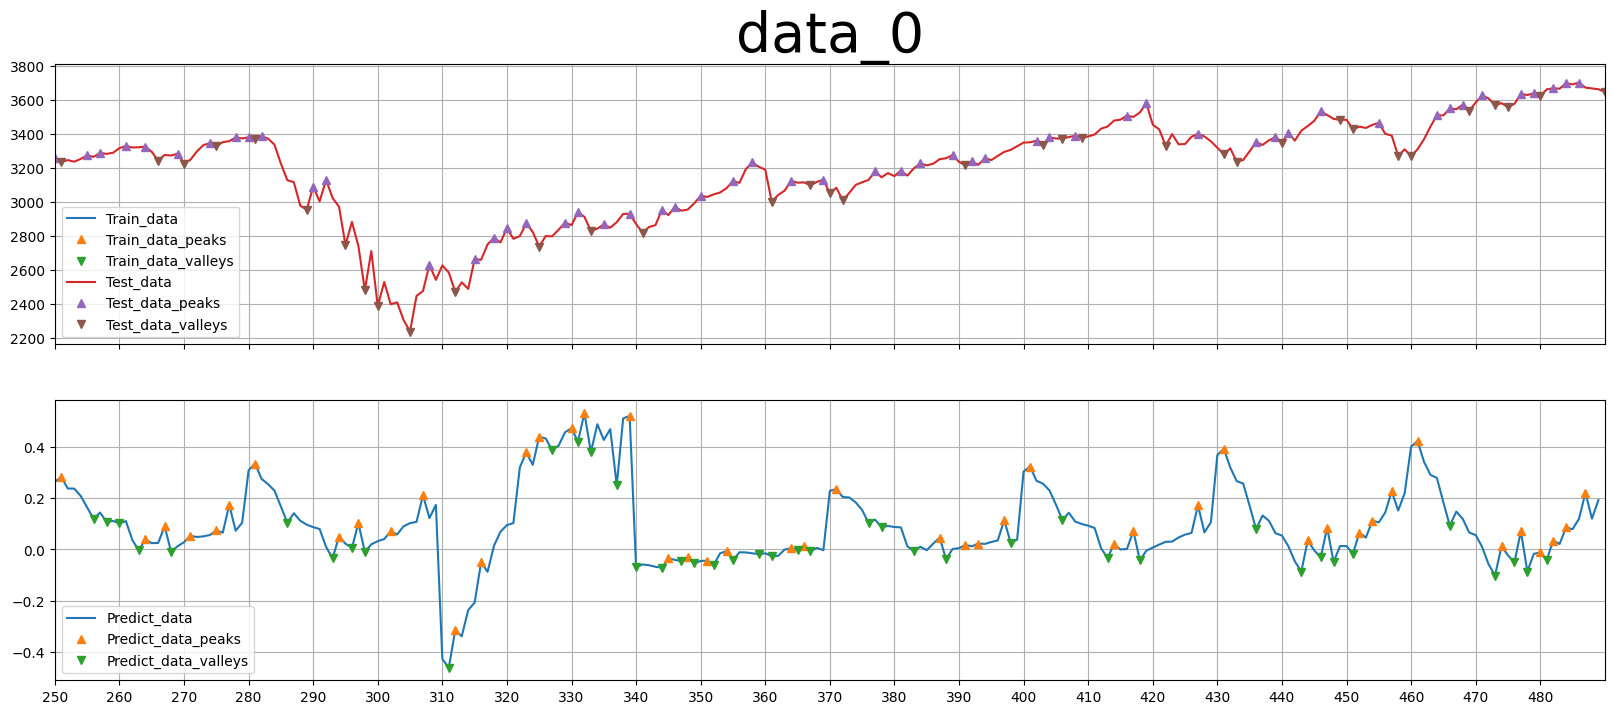

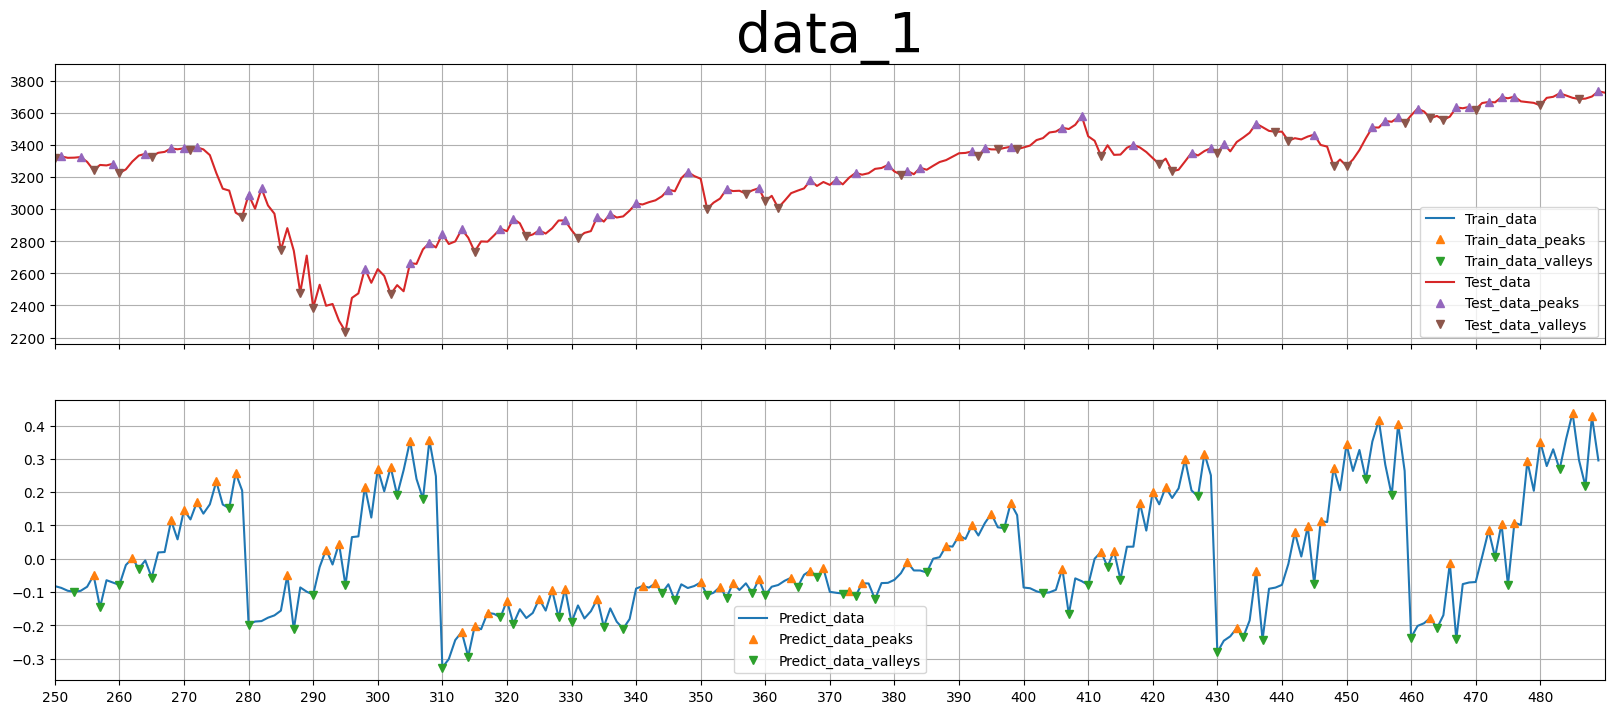

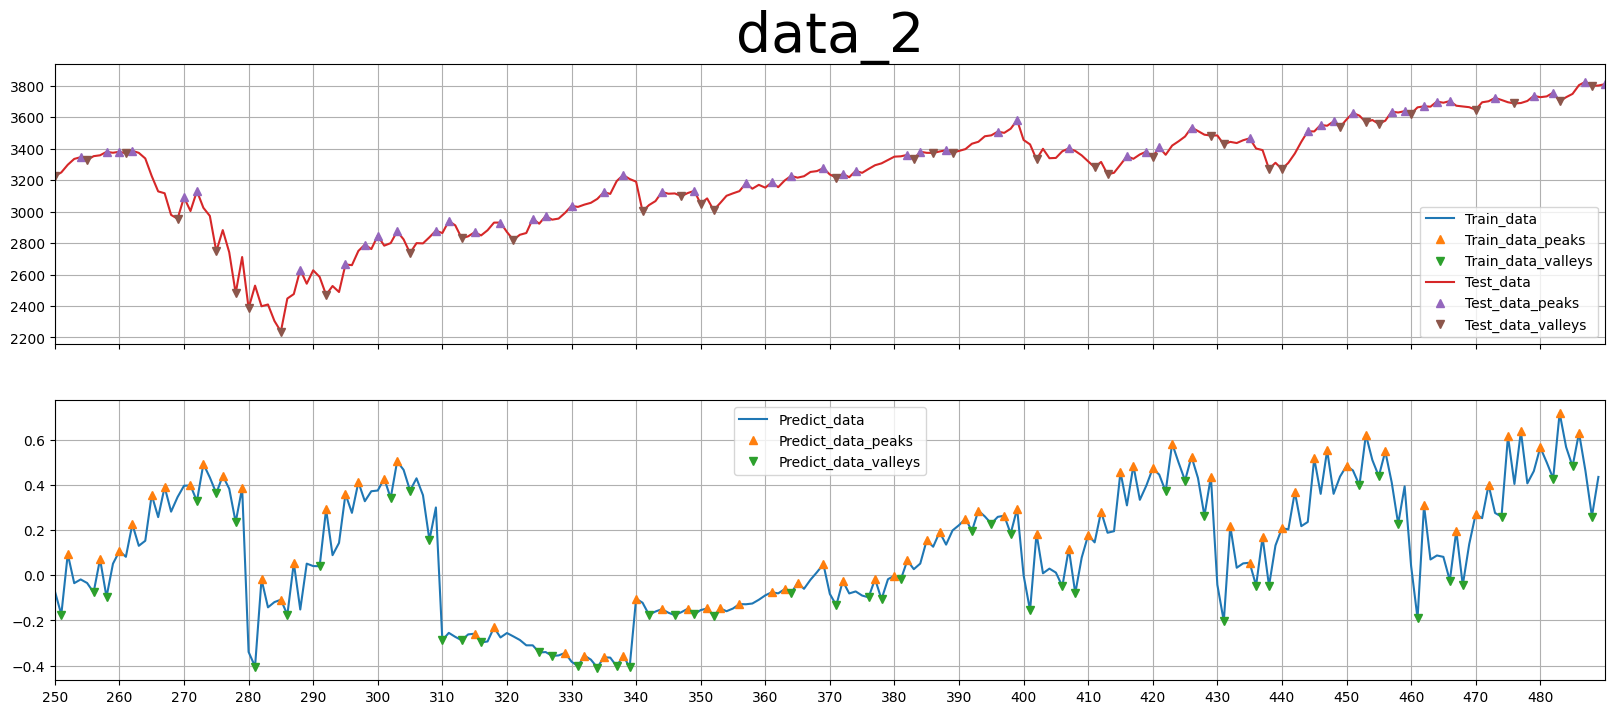

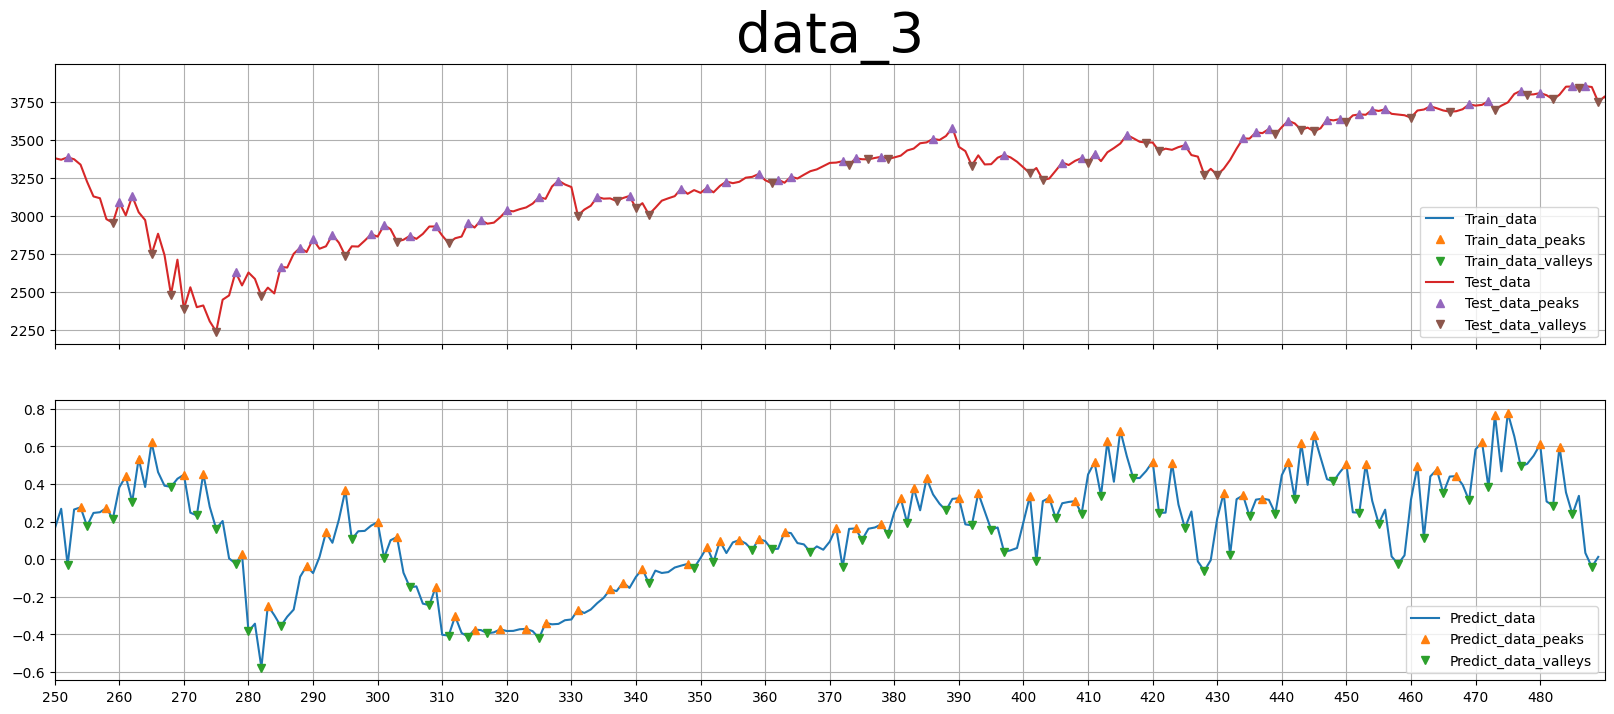

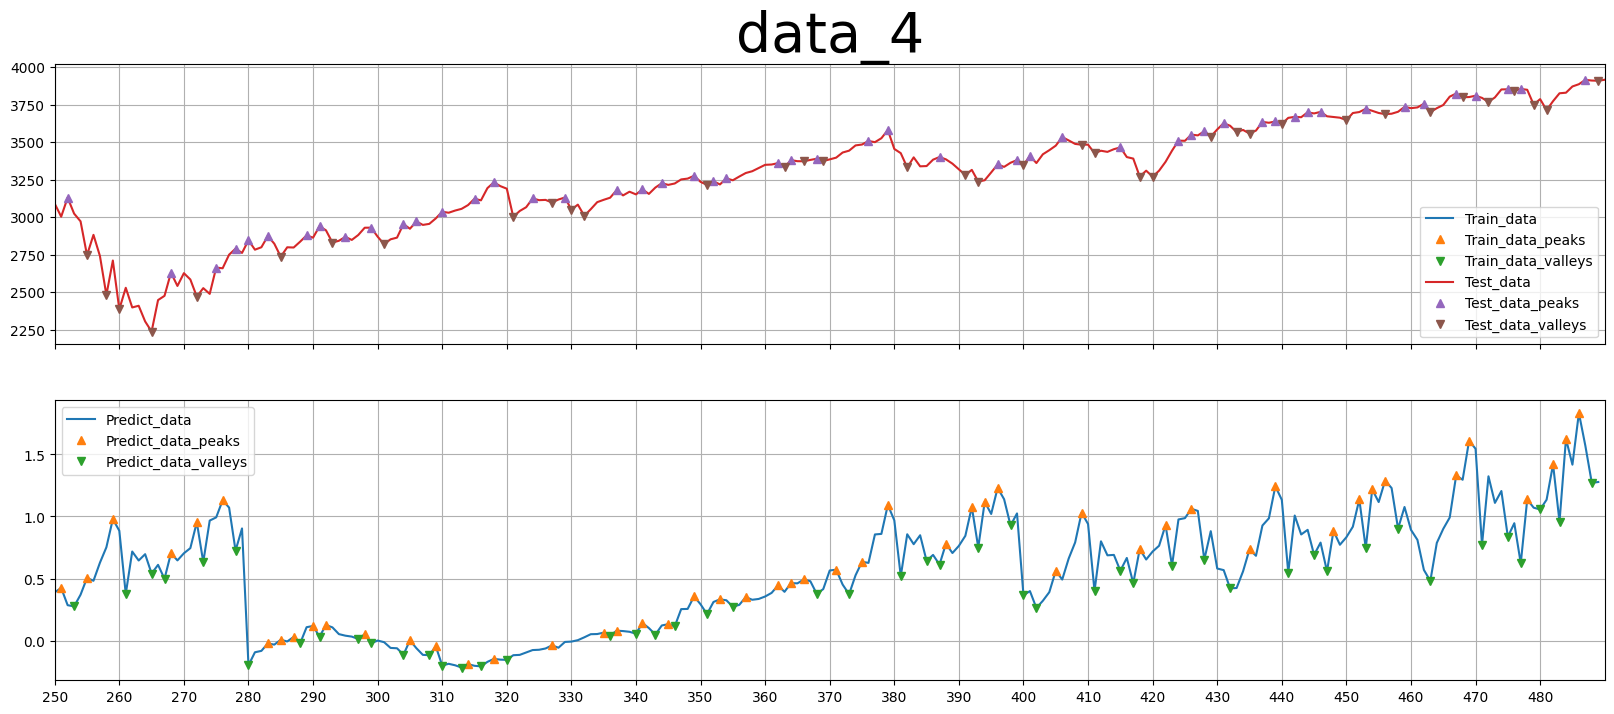

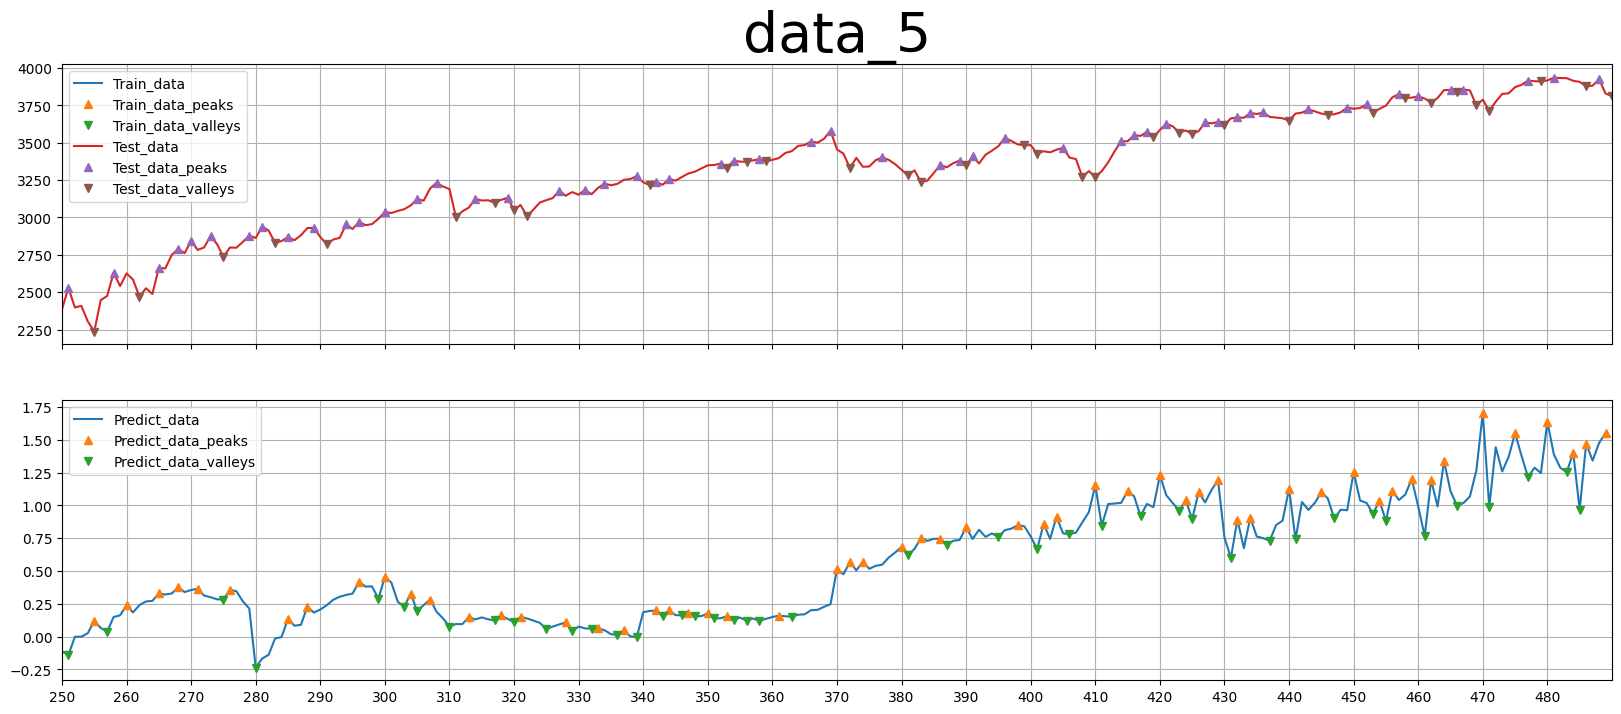

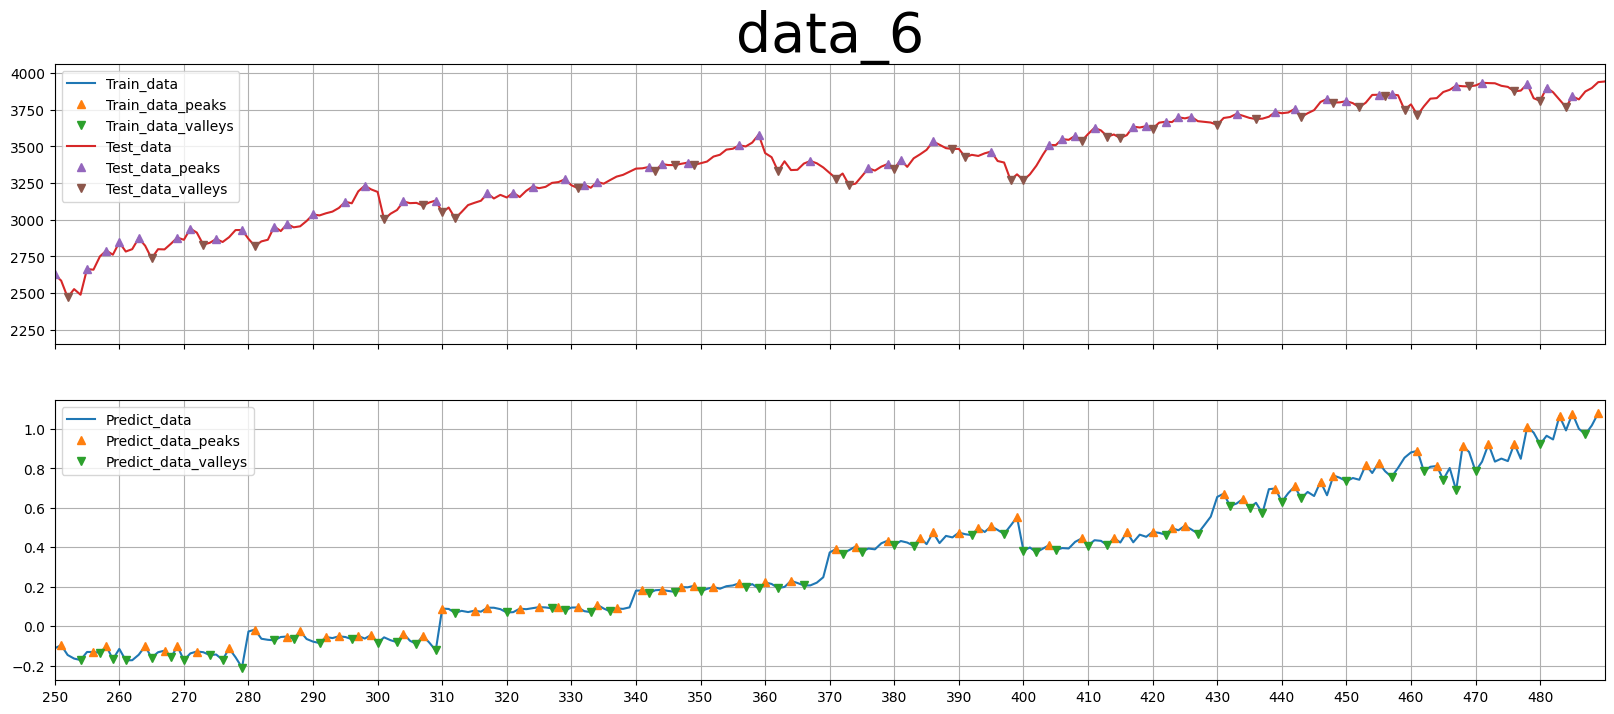

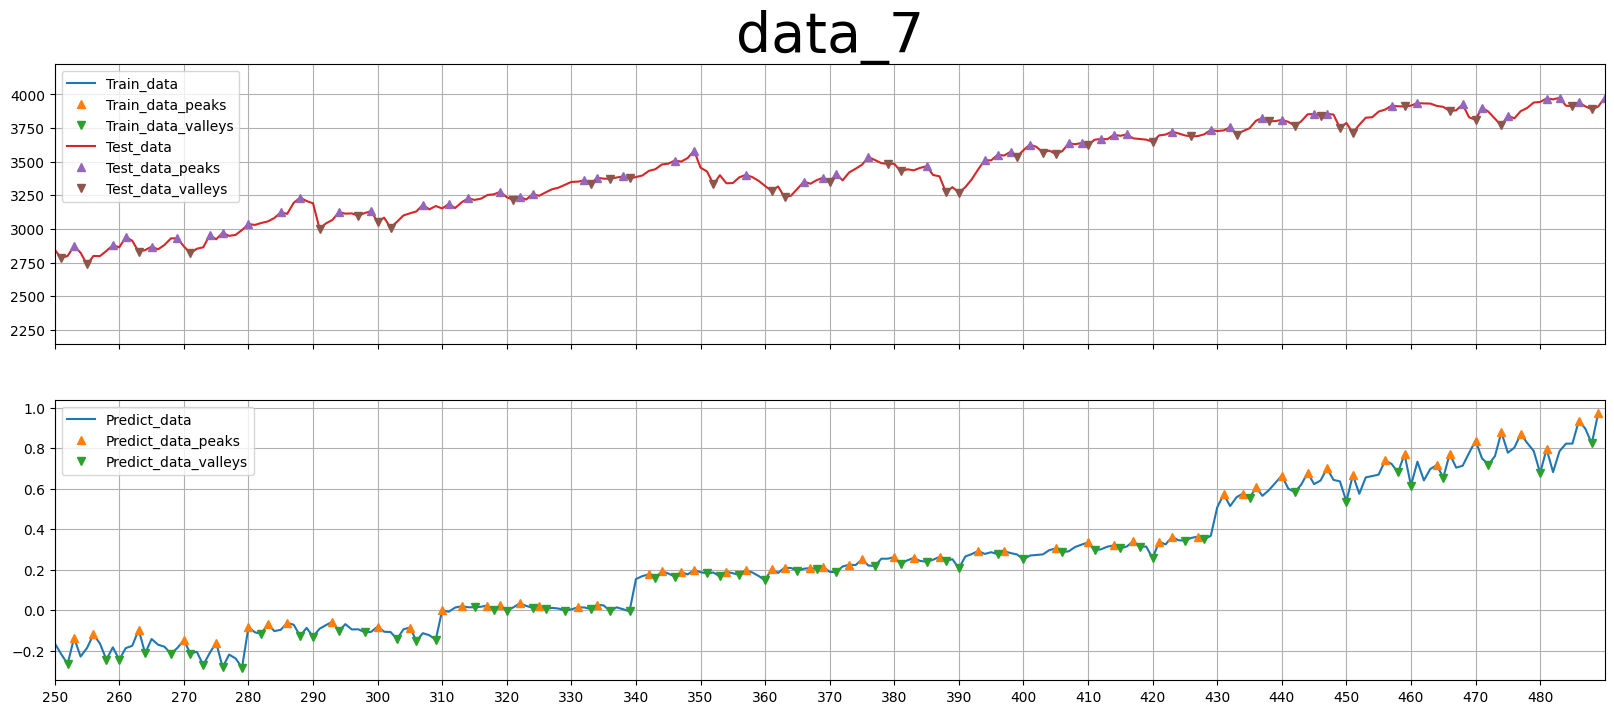

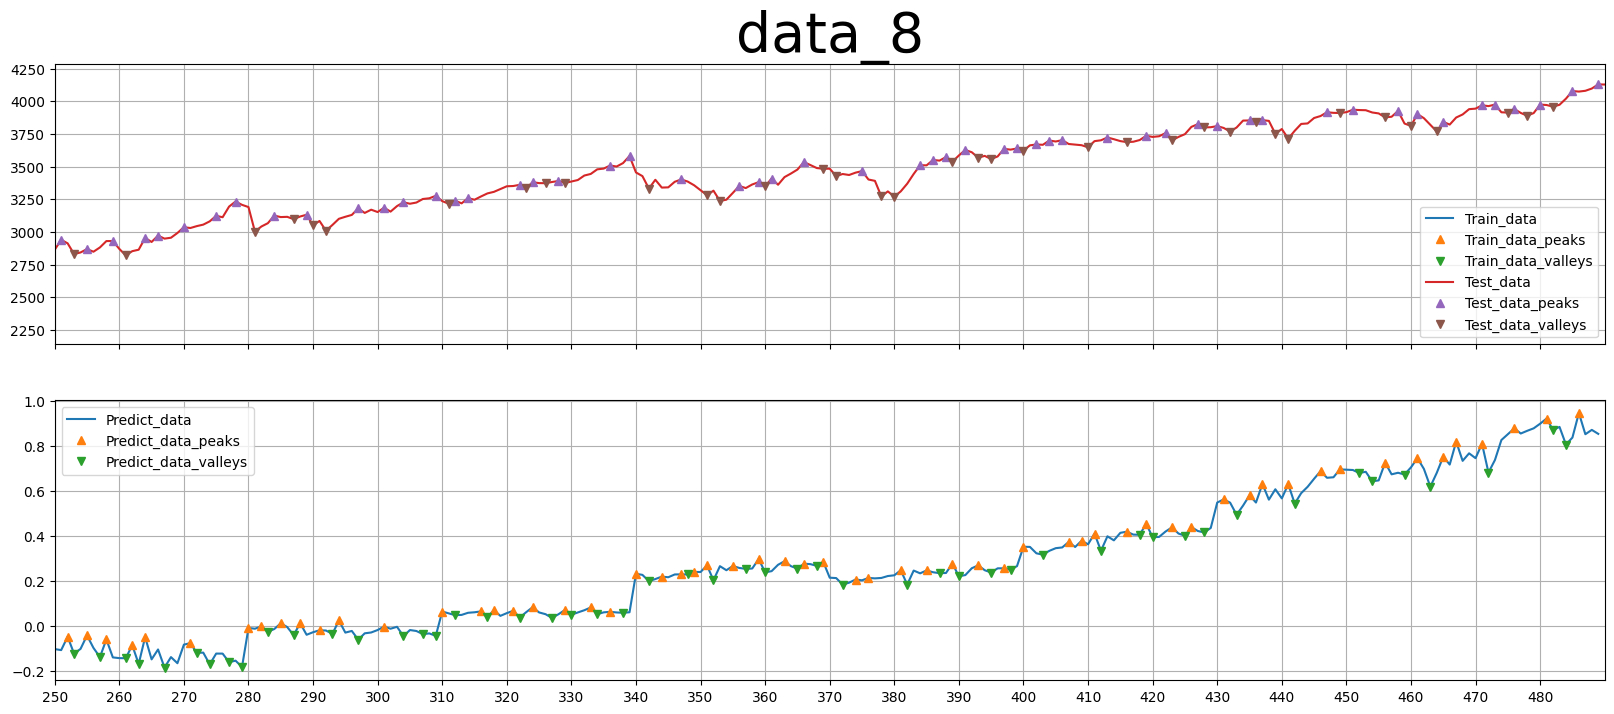

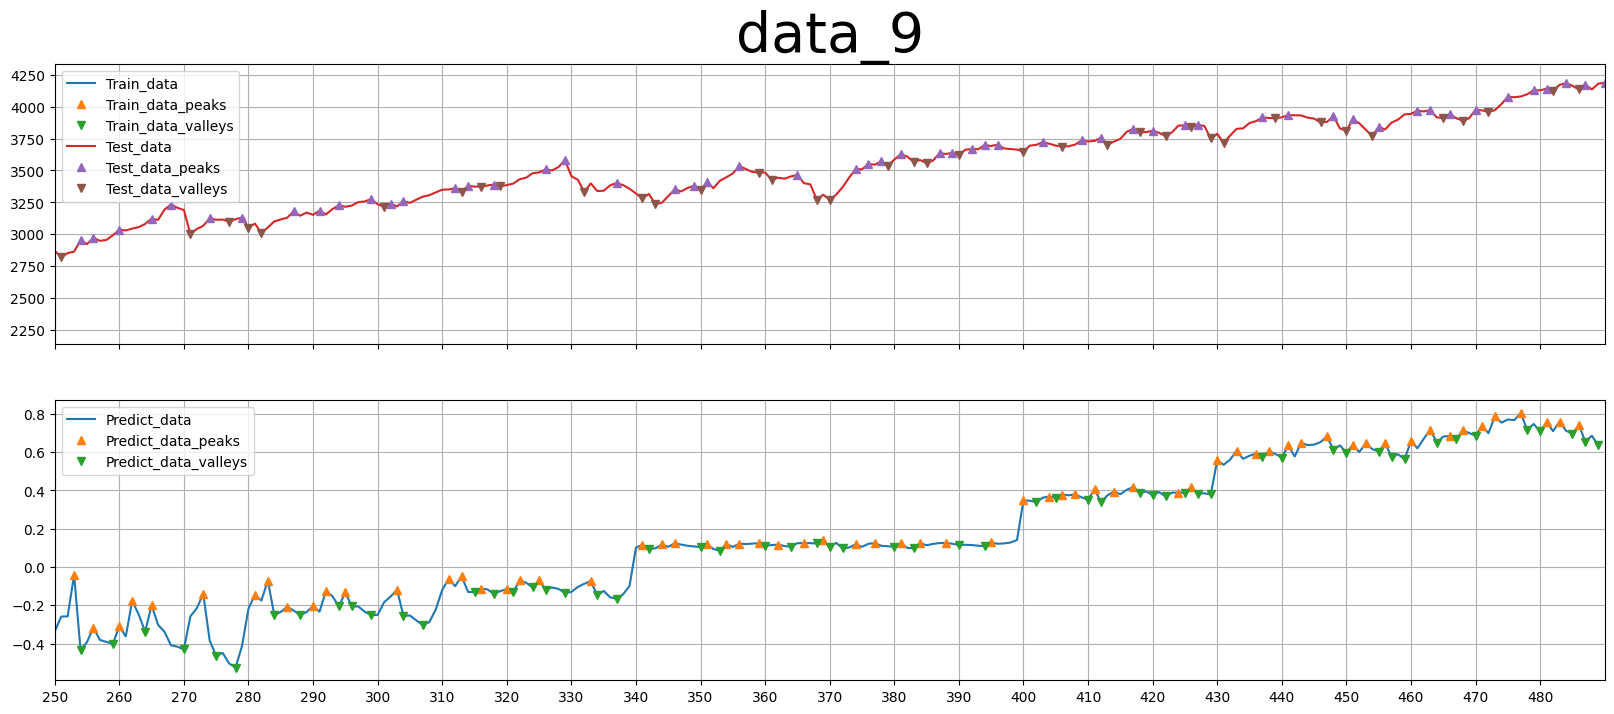

In [63]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'], label='Train_data')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^', label='Train_data_peaks')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v', label='Train_data_valleys')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'], label='Test_data')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^', label='Test_data_peaks')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v', label='Test_data_valleys')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'], label='Predict_data')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^', label='Predict_data_peaks')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v', label='Predict_data_valleys')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    axes[0].legend()
    axes[1].legend()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()

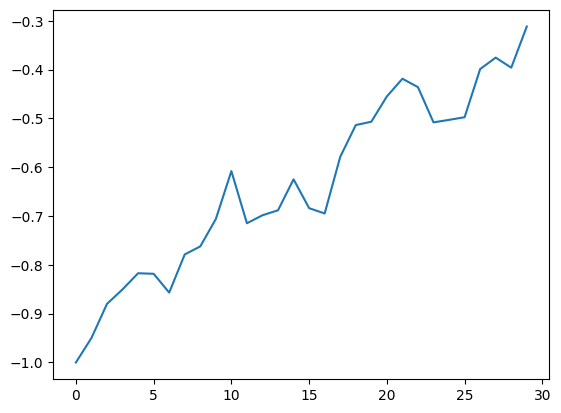

In [64]:
plt.plot(x_train['data_0'][0])

In [65]:
x_train['data_0'].shape[1]

30

In [66]:
for j in range(0, x_train[i].shape[1]):
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [67]:
len(x_train[i][0])

30

In [68]:
# x_start = 0
# x_end = x_start+slide
# for i in x_train:
#     x_start_copy = x_start
#     fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
#     axes[0].set_title(i, fontsize=40)
#     for j in range(0, x_train[i].shape[0]):
#         axes[0].plot(range(x_start, x_end), x_train[i][j], label=f'x_train_{j}')
#         axes[1].plot(range(x_end, x_end+slide), y_train[i][j], label=f'y_train_{j}')
#         x_start+=slide
#         x_end+=slide
#     axes[0].grid()
#     axes[1].grid()
#     axes[0].legend()
#     axes[1].legend()
#     plt.xticks(np.arange(x_start_copy, x_end, step=10))
#     plt.show()

In [69]:
processed_signal['data_0'][0]['Close'].values

array([ 2.63056308e-01,  2.81695217e-01,  2.37002075e-01,  2.36612424e-01,
        2.08123177e-01,  1.63463399e-01,  1.18909597e-01,  1.43410504e-01,
        1.07529938e-01,  1.10736437e-01,  1.01626962e-01,  1.10154182e-01,
        3.65794264e-02, -3.96856107e-03,  3.94071341e-02,  2.42888350e-02,
        2.52508987e-02,  8.99697244e-02, -9.43953730e-03,  1.22465258e-02,
        2.79456638e-02,  5.25266677e-02,  4.82247211e-02,  5.08046523e-02,
        5.57962358e-02,  7.35971481e-02,  6.49906695e-02,  1.73110113e-01,
        7.26165995e-02,  1.03867754e-01,  3.07620883e-01,  3.34324092e-01,
        2.74657071e-01,  2.54164904e-01,  2.28996590e-01,  1.67188898e-01,
        1.03481144e-01,  1.40658036e-01,  1.11644045e-01,  9.62636173e-02,
        8.66605118e-02,  7.92802498e-02,  9.74272750e-03, -3.49475071e-02,
        4.94213775e-02,  2.23537628e-02,  6.14458881e-03,  1.02153450e-01,
       -9.40052420e-03,  1.97021291e-02,  3.21825035e-02,  4.02877927e-02,
        7.05305338e-02,  

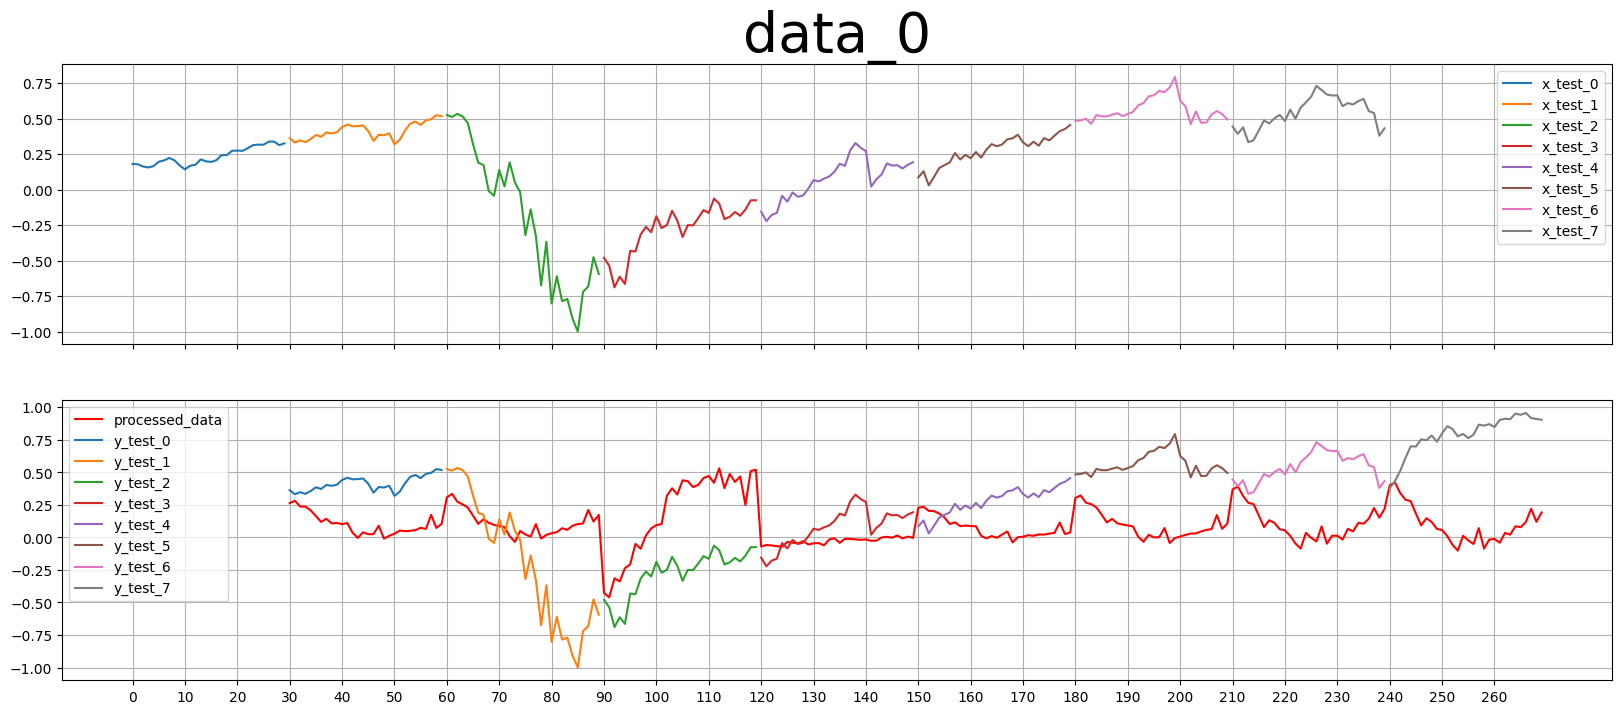

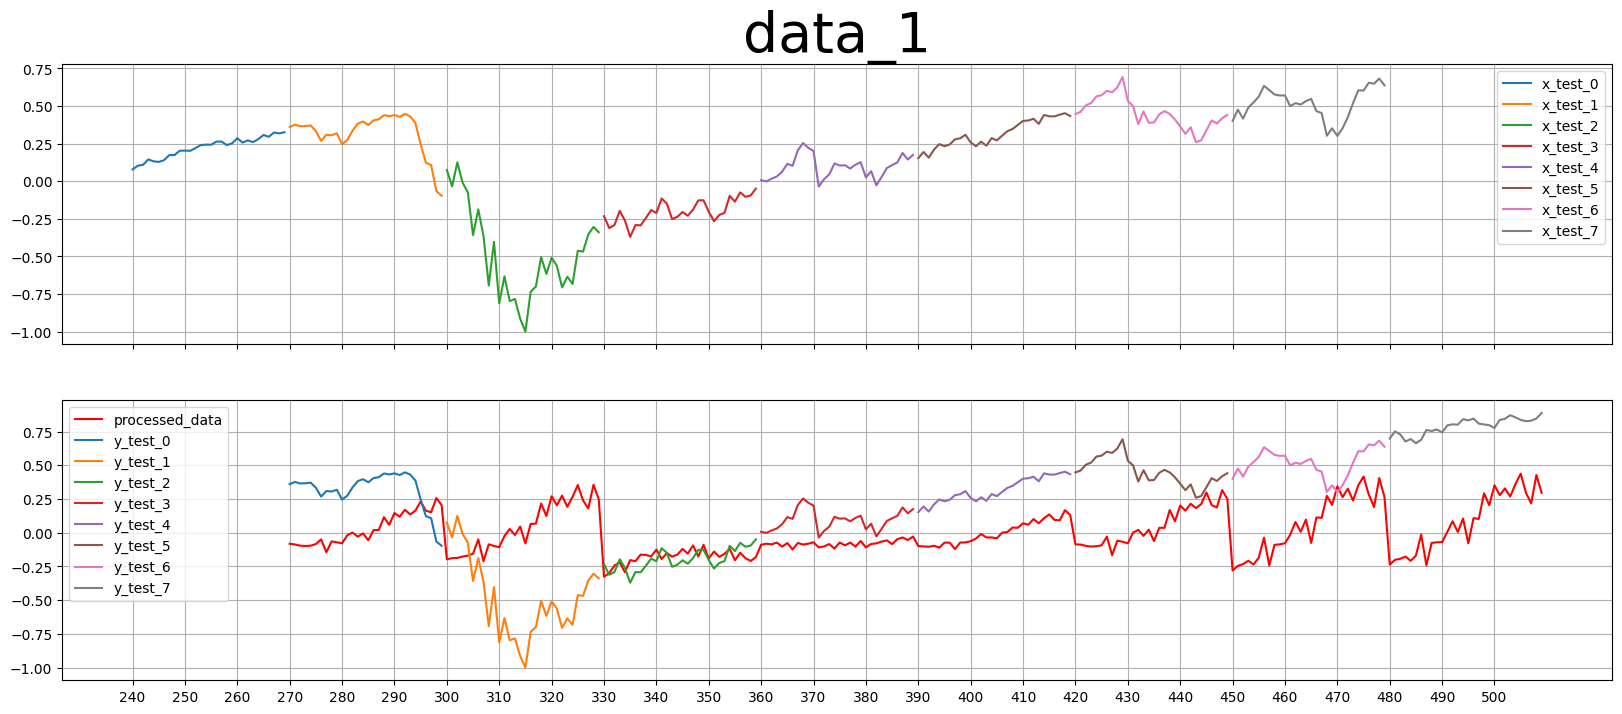

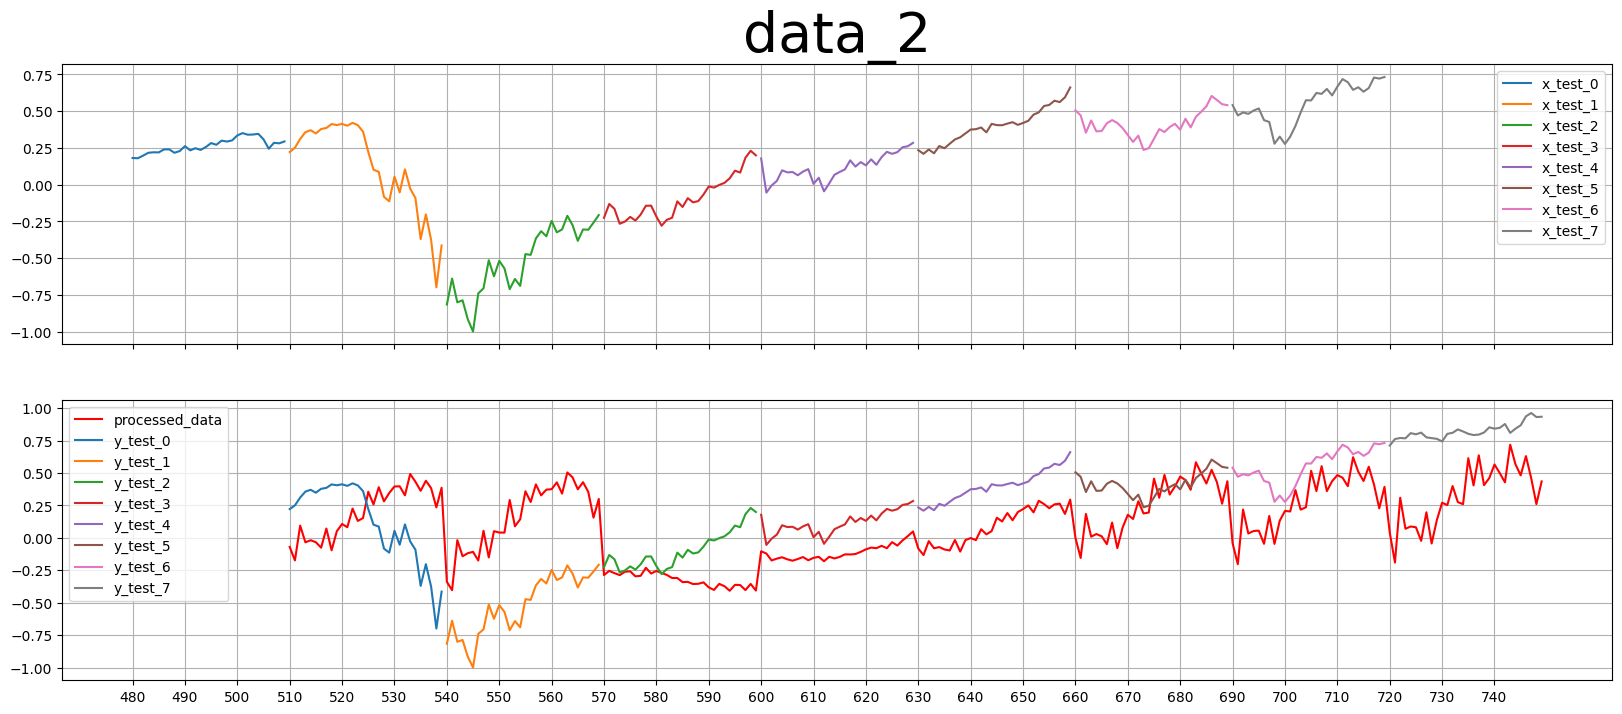

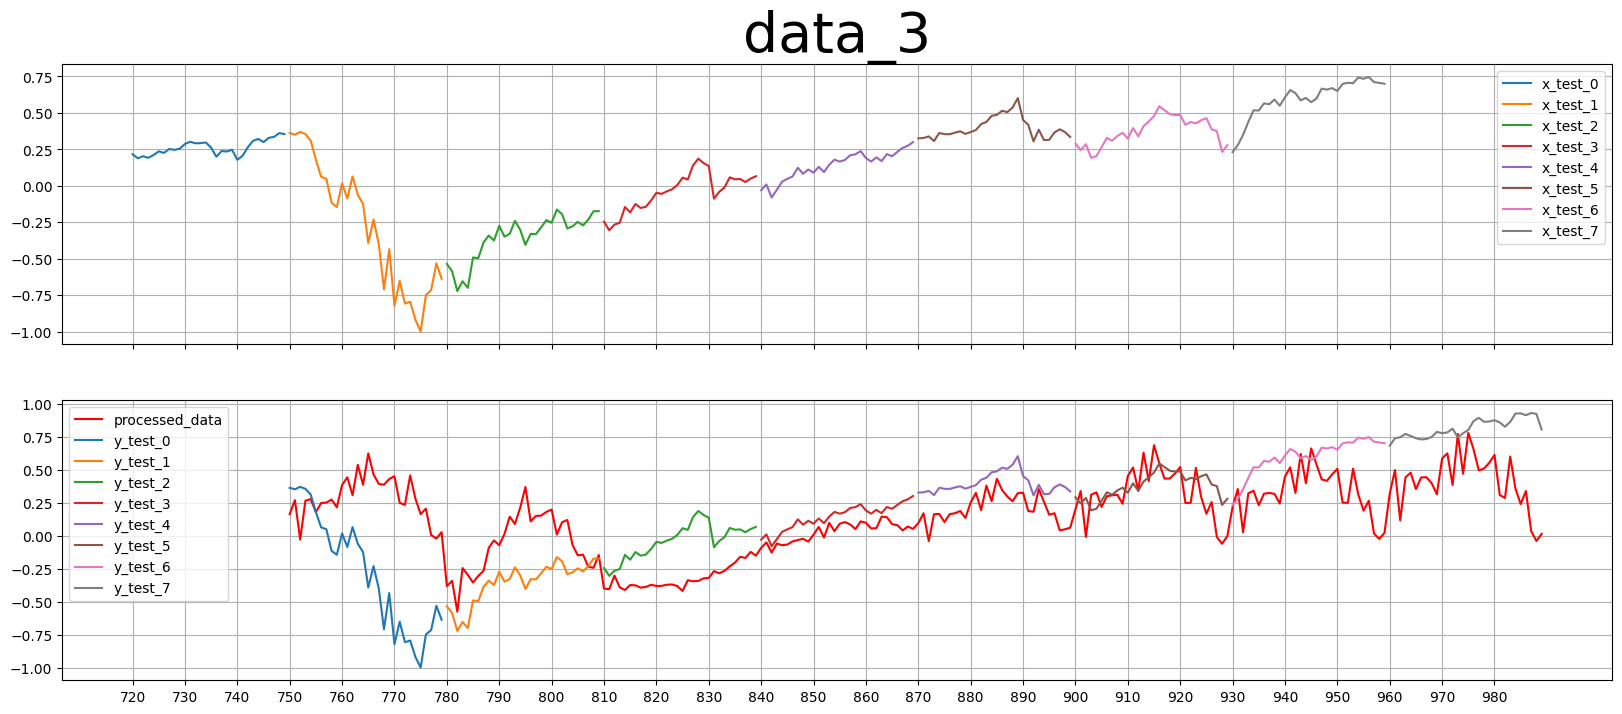

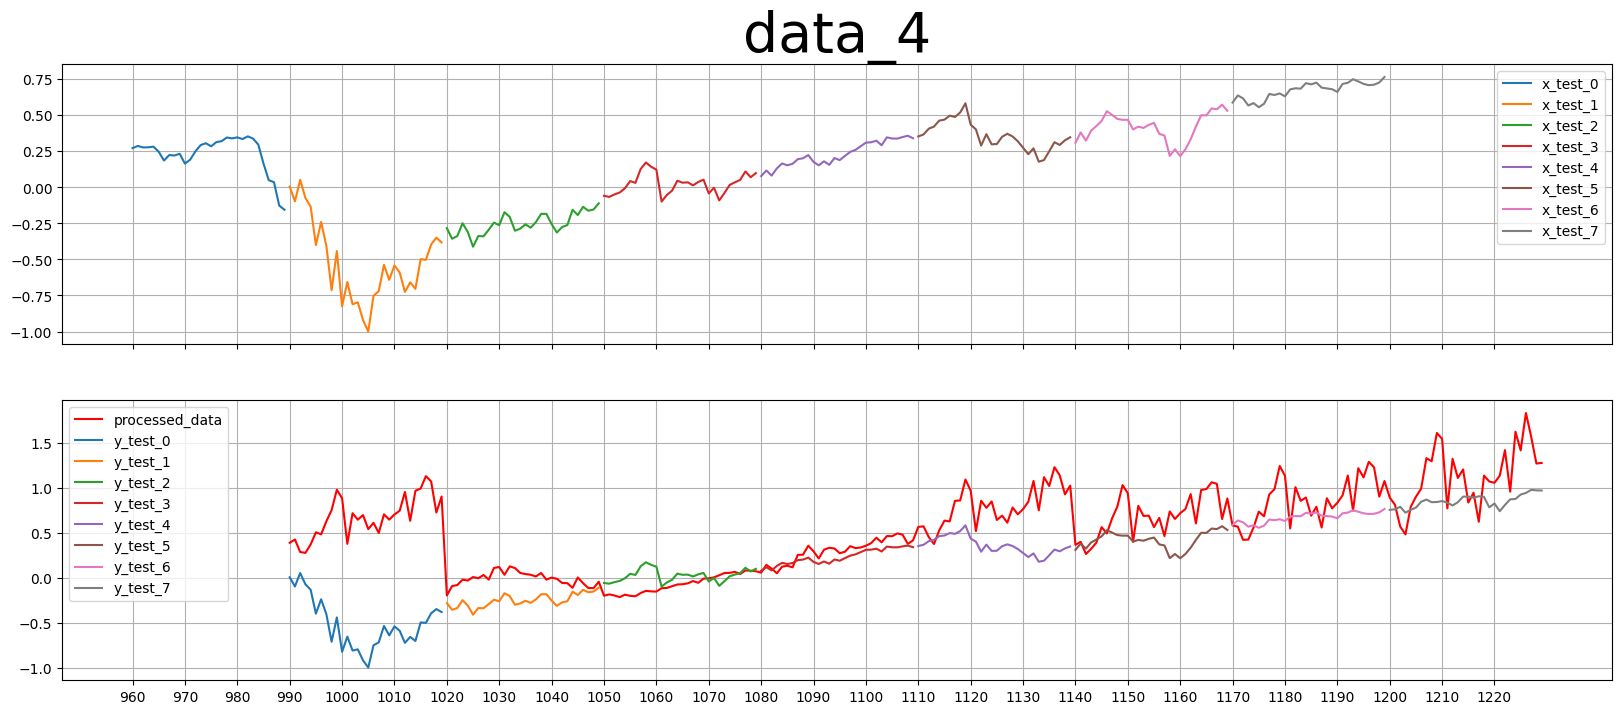

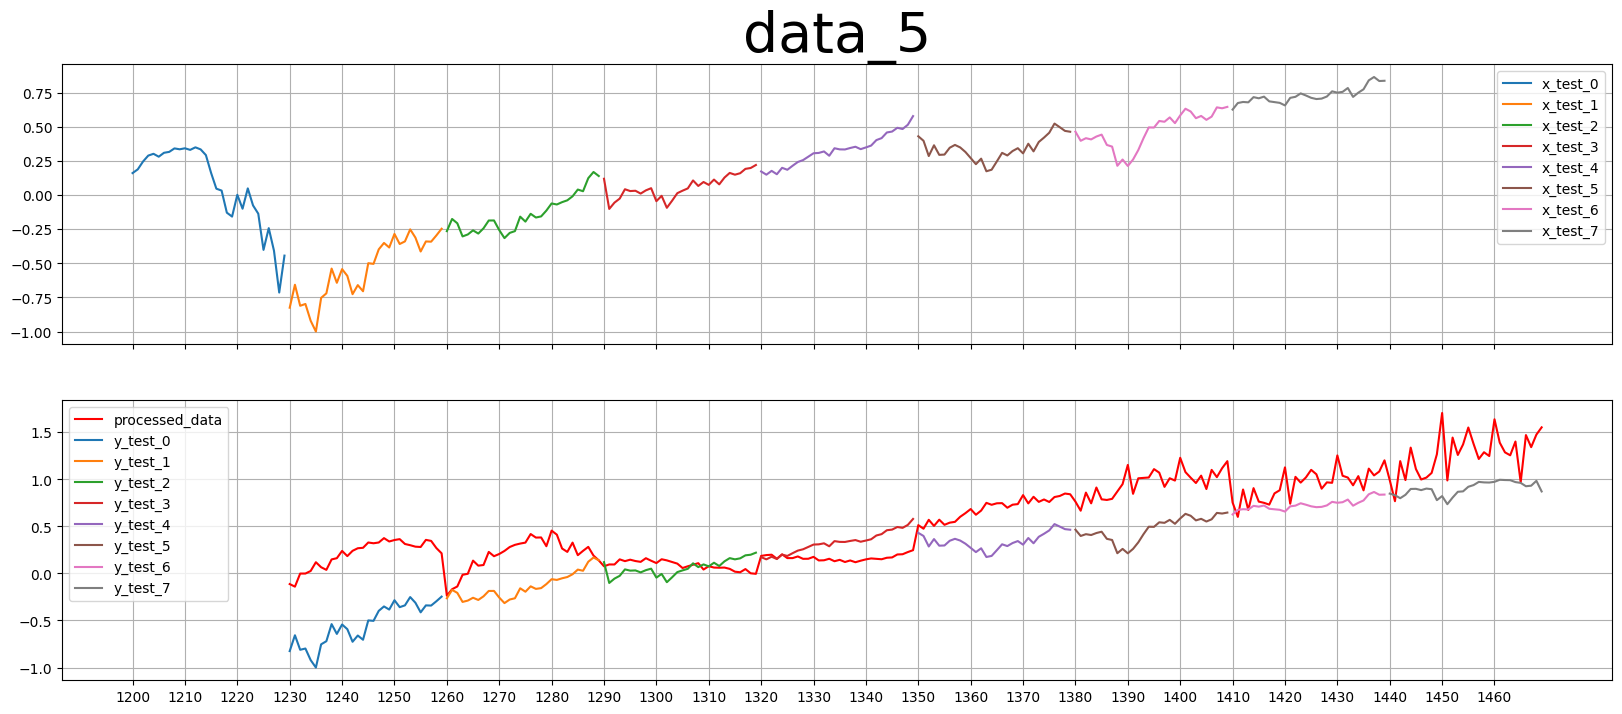

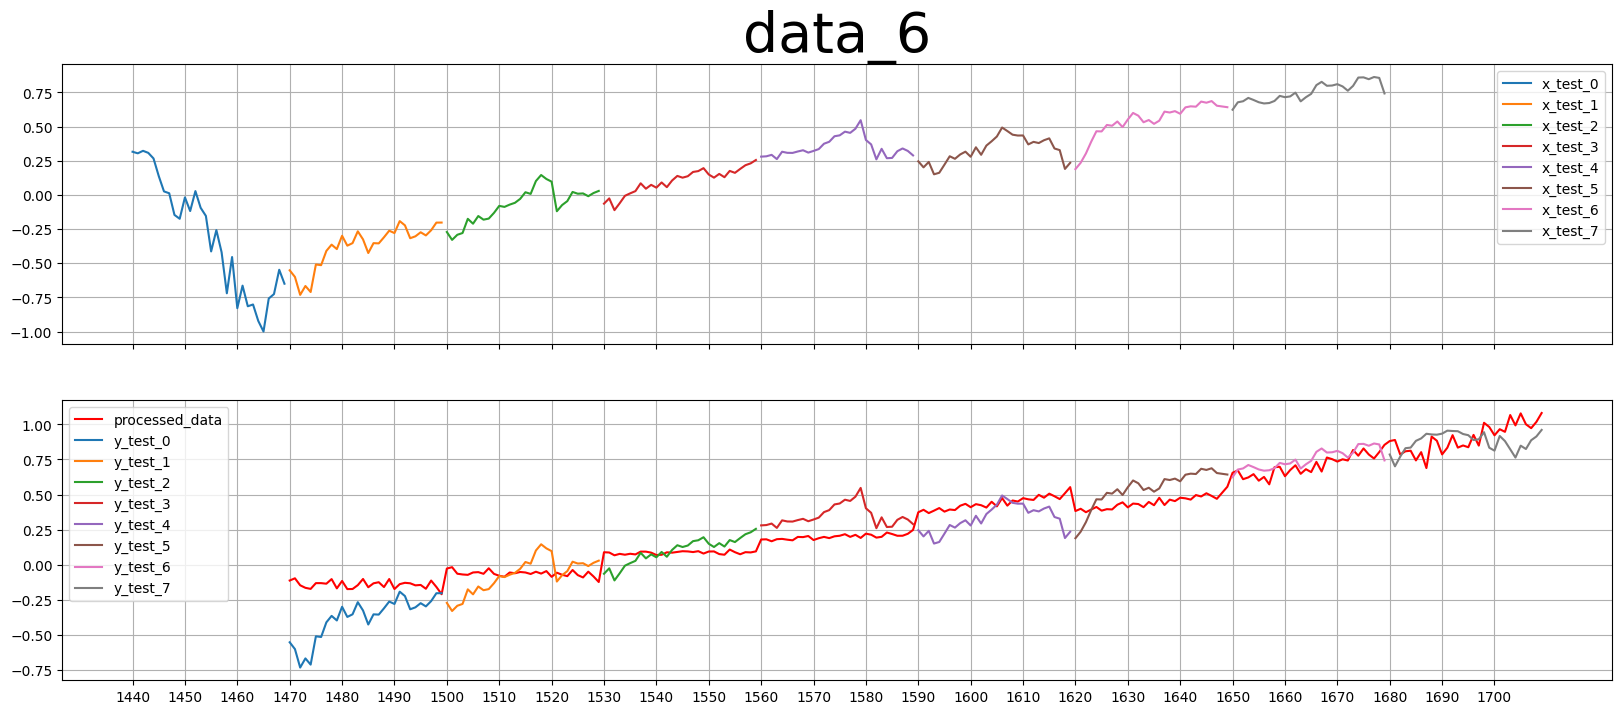

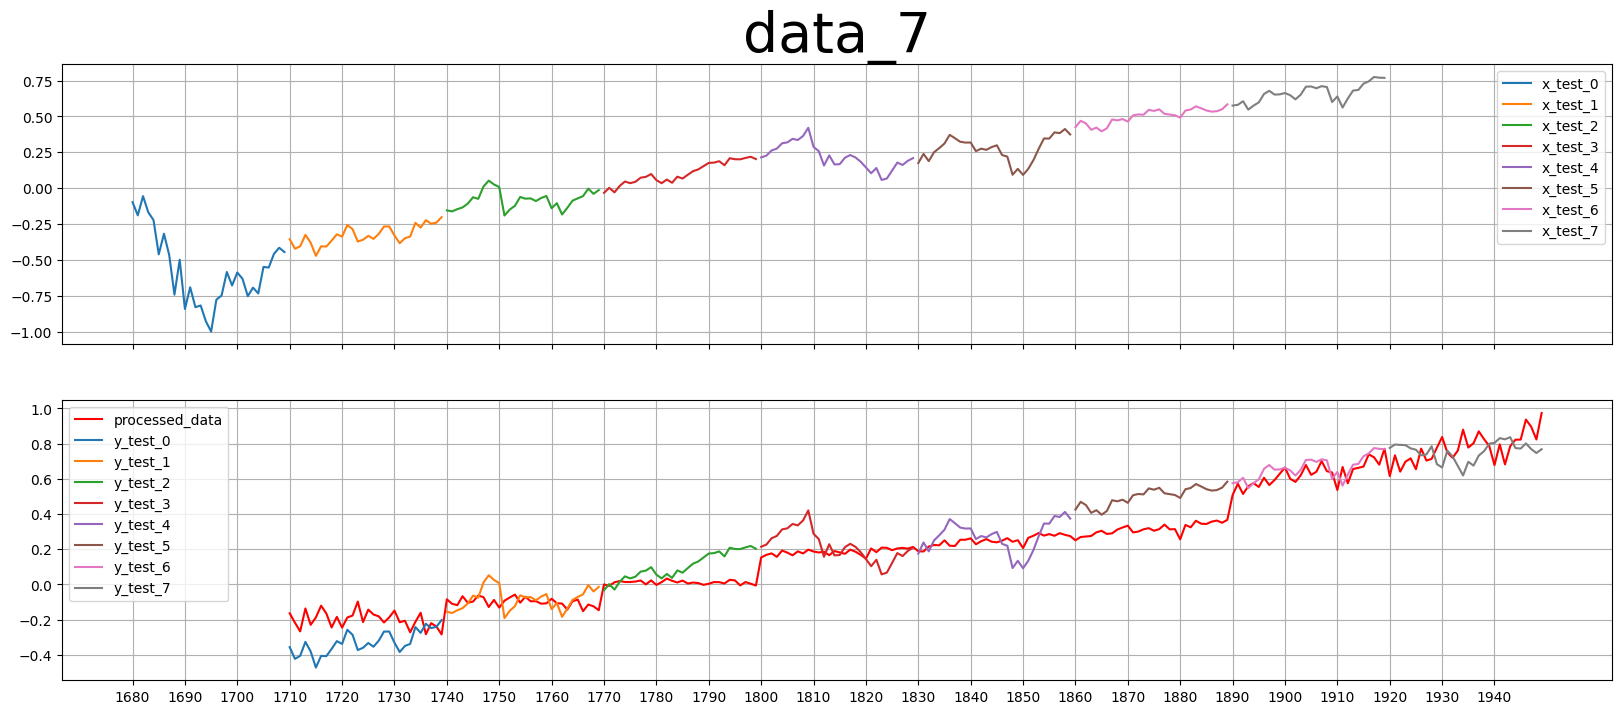

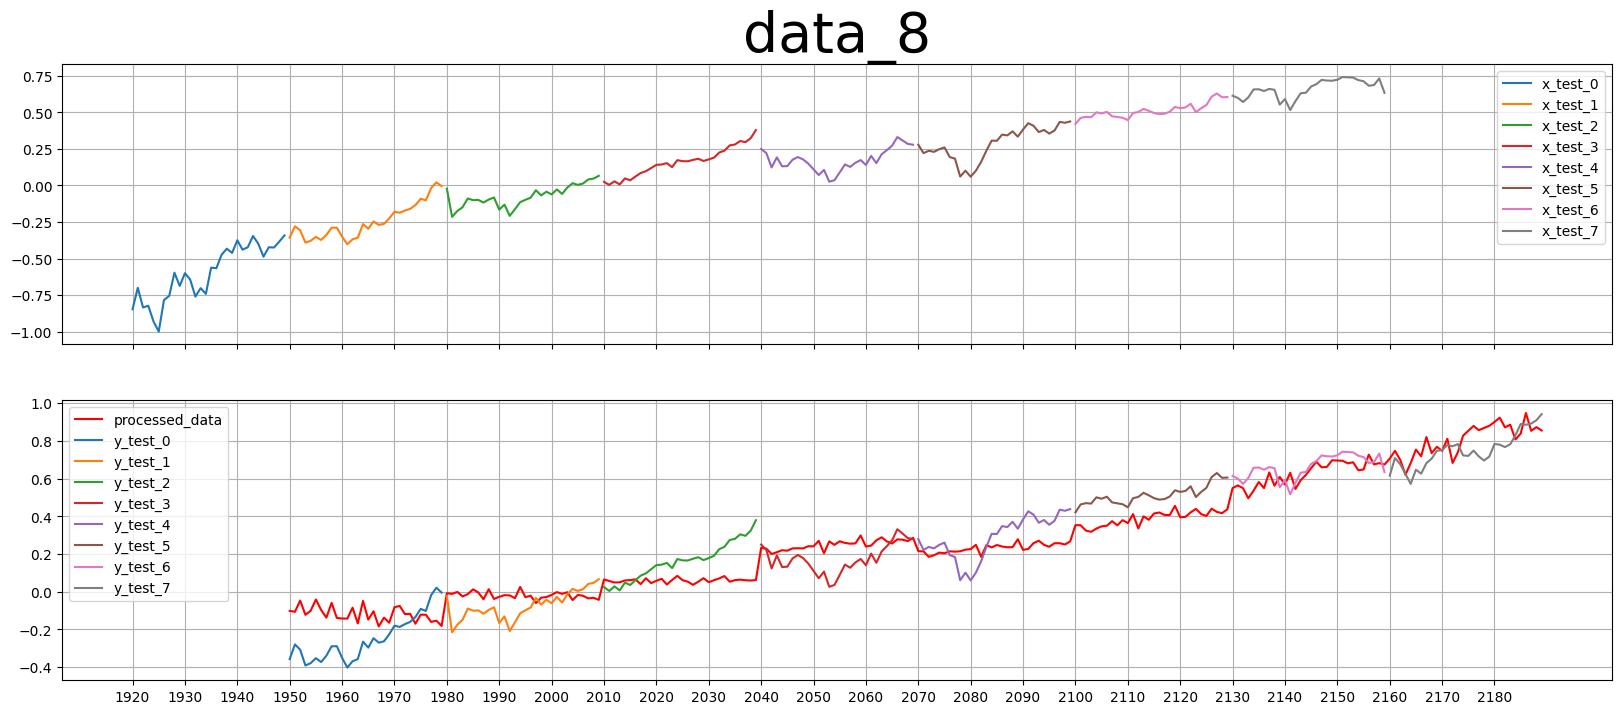

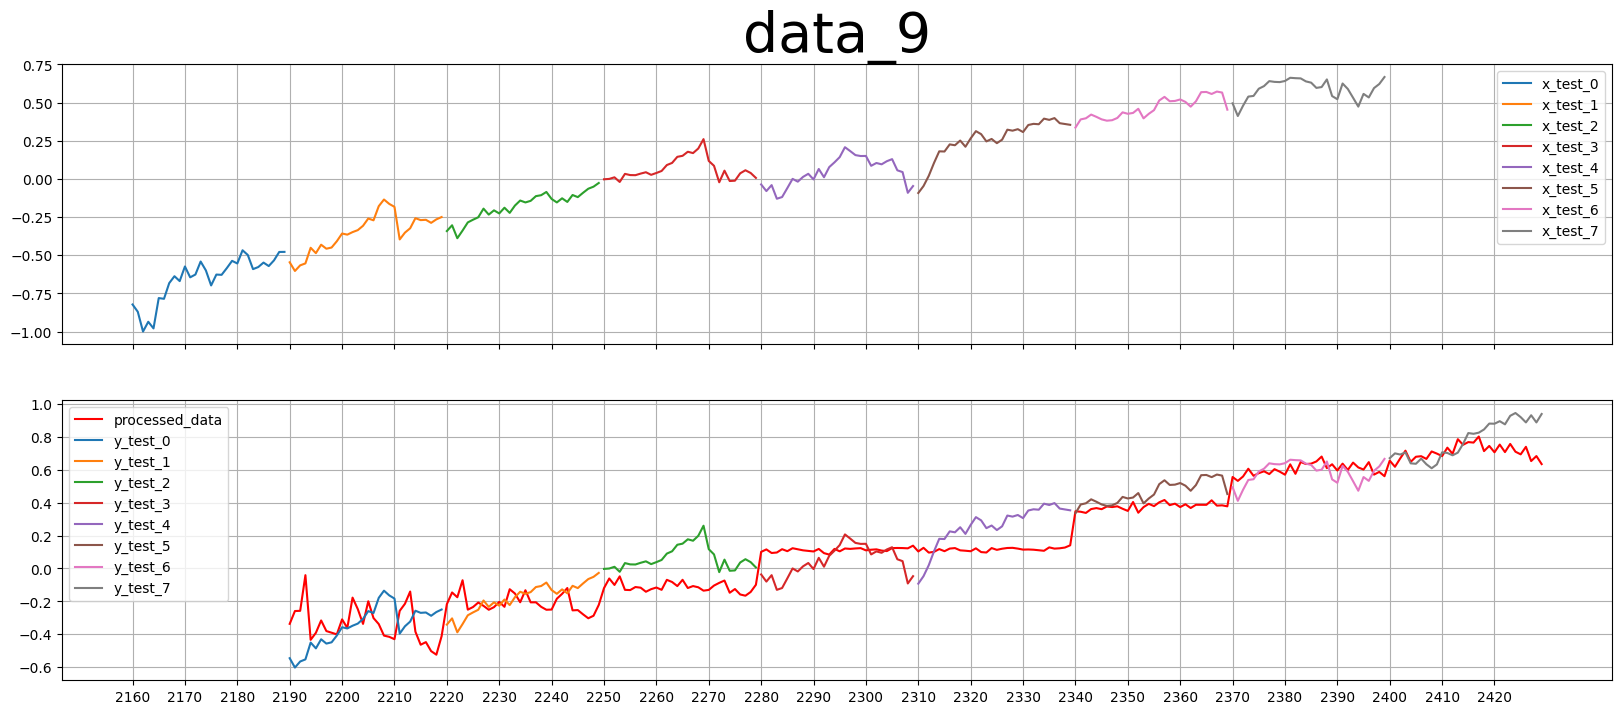

In [70]:
x_start = 0
x_end = x_start+slide
for i in x_test:
    x_start_copy = x_start
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    plot_processed_data = processed_signal[i][0]['Close'].values
    axes[1].plot(range(x_end, x_end+len(plot_processed_data)), plot_processed_data, 'r',label=f'processed_data')
    for j in range(0, x_test[i].shape[0]):
        axes[0].plot(range(x_start, x_end), x_test[i][j], label=f'x_test_{j}')
        axes[1].plot(range(x_end, x_end+slide), y_test[i][j], label=f'y_test_{j}')
        x_start+=slide
        x_end+=slide
    
    axes[0].grid()
    axes[1].grid()
    axes[0].legend()
    axes[1].legend()
    plt.xticks(np.arange(x_start_copy, x_end, step=10))
    plt.show()